# **Detecting FAUs by cropping relevant part of the face and using binary SVM classifiers**

conda env- detect_face

### Contents
*initial parts copied from detectFaceAndLandmarks.ipynb*
1.  **Functions to detect face and landmarks**
2.  ** **
3.  ** **
4.  ** **

** **

Importing libraries

In [12]:
import sys
import os
import random
import glob
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from tqdm import tqdm
from time import sleep

In [14]:
from bcolz import carray

**1. Detecting face and visualising landmarks**

In [15]:
args={"shape_predictor":"shape_predictor_68_face_landmarks.dat"}

In [16]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

Function to detect faces and save in a txt file{image_name_landmarks1.txt} after detector and predictor are defined

In [17]:
def detectFace(impath):
    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(impath)
#     image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
#         print(shape.shape)
        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 10)
        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        basePath=impath.split('.')[0]
#         uncomment lines to write the landmarks to a text file
        lmpath=basePath+"_landmarks"+str(i+1)+".txt"
        text_file = open(lmpath, "w")
        for (x, y) in shape:
#             print x,y
            cv2.circle(image, (x, y), 10, (0, 0, 255), -1)
            text_file.write(str(x)+' '+str(y)+'\n')
        text_file.close()
        
    # cv2.imshow("im", image)
    # cv2.waitKey(1000)
#     print 'These are the detected faces and the landmarks, which have been written to : ', lmpath
#     print imageTouse.shape,
#     print 'landmarks written to: ', lmpath
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
#         plt.imshow(image)
    return lmpath

'/home/amogh/cmu/notebooks/face_landmarks1.txt'

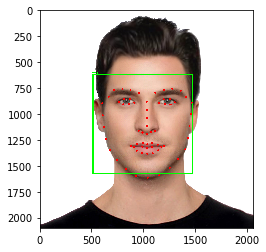

In [18]:
sample_image_path='/home/amogh/cmu/notebooks/face.jpg'
detectFace(sample_image_path)

## Cropping and aligning face

#### Helper functions: (see details in *tryAlignmentWarping.ipynb*)

In [19]:
# Read points from text files in directory
def readPoints(path) :
    pointsArray = [];
    points = [];   
#     print(path)
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(float(x)), int(float(y))))
    pointsArray.append(points)
    return pointsArray;

# Read all jpg images in folder.
def readImages(path) :
    imagesArray = [];
    img = cv2.imread(path);
    img = np.float32(img)/255.0;
    imagesArray.append(img);
    return imagesArray;
                
# Compute similarity transform given two sets of two points, OpenCV requires 3 pairs of corresponding points, we are faking the third one.
def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180);
    c60 = math.cos(60*math.pi/180);  
  
    inPts = np.copy(inPoints).tolist();
    outPts = np.copy(outPoints).tolist();
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0];
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1];
    
    inPts.append([np.int(xin), np.int(yin)]);
    
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0];
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1];
    
    outPts.append([np.int(xout), np.int(yout)]);
    
    tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False);
    
    return tform;

#### Function to align image

The code is in such a form so that refactoring allows calculating average landmarks for multiple images

In [20]:
def alignAndcrop(img_abs_path, landmark_abs_path):
    # Dimensions of output image
    w = 112;
    h = 112;
    landmark_path=landmark_abs_path
    allPoints = readPoints(landmark_path);
    images = readImages(img_abs_path);
    # Eye corners
    eyecornerDst = [ (np.int(0.3 * w ), np.int(h / 3)), (np.int(0.7 * w ), np.int(h / 3)) ];
    imagesNorm = [];
    pointsNorm = [];
#     print allPoints[0]
    # Add boundary points for delaunay triangulation
    boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ]);
    n = len(allPoints[0]);
    numImages = len(images)
    for i in xrange(0, numImages):
        points1 = allPoints[i];
        # Corners of the eye in input image
        eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] ;
        # Compute similarity transform
        tform = similarityTransform(eyecornerSrc, eyecornerDst);
        # Apply similarity transformation
        img = cv2.warpAffine(images[i], tform, (w,h));
#         print("debug im type shape max mean min ", img.dtype,img.shape,np.max(img),np.mean(img),np.min(img))
#         plt.imshow(img)
        # Apply similarity transform on points
        points2 = np.reshape(np.array(points1), (68,1,2));        
        points = cv2.transform(points2, tform);
        points = np.float32(np.reshape(points, (68, 2)));
        pointsNorm.append(points);
        imagesNorm.append(img);
#     print (pointsNorm[0])
#     plt.imshow(imagesNorm[0]) 
    # Output image
    output=imagesNorm[0]
#     for (x, y) in pointsNorm[0][]:
# #             print x,y
#             cv2.circle(output, (x, y), 2, (0, 0, 255), -1)
    writeToFile=False
    if writeToFile==True:
        pass
#         cv2.imwrite('cropped.bmp',output*255)
#     cv2.imshow('image', output)
#     cv2.waitKey(0)
    return output,pointsNorm[0]

In [21]:
def detectAndaligncrop(impath):
    lmpath=detectFace(impath)
    finalimage,finalpoints=alignAndcrop(impath,lmpath)
#     print 'final cropped image: ', finalimage.shape
#     cv2.imshow(finalimage)
#     cv2.waitKey(5000)
#     print("debug2 im type shape max mean min ", finalimage.dtype,finalimage.shape,np.max(finalimage),np.mean(finalimage),np.min(finalimage))
    rgb_image=cv2.cvtColor(finalimage,cv2.COLOR_BGR2RGB)
#     print("debug3 im type shape max mean min ", rgb_image.dtype,rgb_image.shape,np.max(rgb_image),np.mean(rgb_image),np.min(rgb_image))
    plt.imshow(rgb_image)
    return rgb_image,finalpoints

## Testing preprocessing on sample images

In [22]:
# imageTouse='/media/amogh/Stuff/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003/S999_003_00000055.png'
# imageTouse='/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN013/001.jpeg'
# imageTouse='/home/amogh/cmu/dataset/BP4D/BP4D-training/F001/T1/2440.jpg' #BP4D images
imageTouse="files_may20/1.jpeg" #DISFA sample images
# imageTouse='/media/amogh/OS/Users/AMOGH GUPTA/Desktop/CMU/Face Alignment/FaceAverage/presidents/barak-obama.jpg'

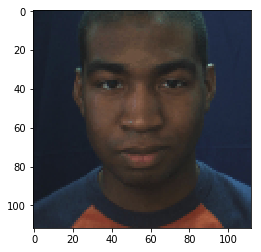

In [23]:
sample_alignedAndCropped,landmarkPoints=detectAndaligncrop(imageTouse)

In [24]:
np.max(sample_alignedAndCropped)

0.7217448

Cropping relevant parts of the face to detect an FAU

In [25]:
sample_im=cv2.imread('/home/amogh/cmu/notebooks/files_may20/facial-au-regions.png')

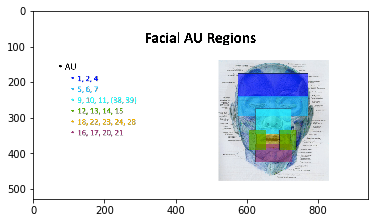

In [26]:
plt.imshow(sample_im)

Action units required for educationally relevant emotions- 1,2,4,5,7,12,43,25,26,

Frustration

    1 - Inner Brow Raise
    2 - Outer Brow Raise

Confusion

    4 - Brow Lowerer
    7 - Lid Tightener

Boredum

    43 - Eye Closure

Surprise

    1 - Inner Brow Raiser
    2 - Outer Brow Raiser
    5 - Upper Lid Raiser
    26 - Jaw Drop

Delight

    7 - Lid Tightener
    12 - Lip Corner Puller
    25 - Lips Part
    26 - Jaw Drop


#### Preprocessing code for the topmost region (FAU 1,2,4)

The top part of the eyes is FAUs 38,39,44,45; so let's take the average of the y coordinate of these

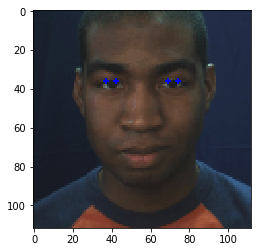

In [27]:
temp_fau_vis=sample_alignedAndCropped.copy()
for (x, y) in landmarkPoints[np.array([37,38,43,44])]:
    cv2.circle(temp_fau_vis, (x, y), 1, (0, 0, 255), -1)
plt.imshow(temp_fau_vis)

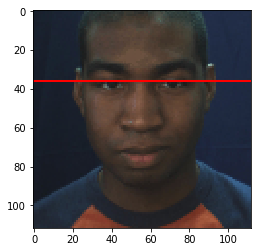

In [28]:
temp_line_vis=sample_alignedAndCropped.copy()
top_eyes=np.average([y for _,y in landmarkPoints[np.array([37,38,43,44])]])
cv2.line(temp_line_vis,(0,top_eyes),(temp_line_vis.shape[1],top_eyes),(255,0,0),1)
plt.imshow(temp_line_vis)

Cropping the part of the image above this line

In [29]:
int(top_eyes)

36

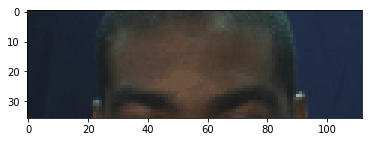

In [30]:
cropped_sample=sample_alignedAndCropped[0:int(top_eyes)]
plt.imshow(cropped_sample)

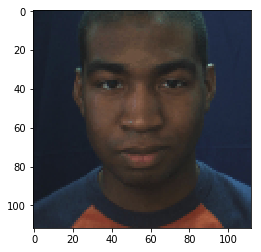

In [31]:
cropped_sample=sample_alignedAndCropped
plt.imshow(cropped_sample)

Debug - You can change the list of landmark numbers and visualise them, or add a black rectangle.

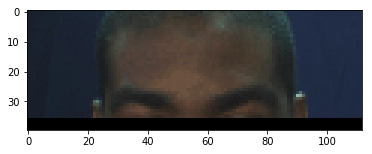

In [126]:
temp_mask=sample_alignedAndCropped.copy()
top_eyes=np.max([y for _,y in landmarkPoints[np.array([37,38,43,44])]])
# cv2.line(temp_mask,(0,top_eyes),(temp_mask.shape[1],top_eyes),(255,0,0),1)
# for (x, y) in landmarkPoints[np.array([37,38,43,44,19,20,21,22,24,25,26,27])]:
#     cv2.circle(temp_mask, (x, y), 1, (0, 0, 255), -1)
threshold=min(40, int(top_eyes))
masked_im=np.vstack((temp_mask[:int(top_eyes)],np.zeros((40-threshold,112,3),np.float32)))
# masked_im=np.vstack((temp_mask[:int(top_eyes)],np.repeat([temp_mask[int(top_eyes)]],(40-threshold),axis=0)))
plt.imshow(masked_im)

### Calculating HOG features

In [32]:
from skimage.feature import hog
from skimage import data,exposure

Some **debugging blocks** to analyse the shape and values of the images, datatype is integer when you read an image, it is float when we pass it through our function

In [70]:
fd1, hog_image1 = hog(gray_im, orientations=16, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled1 = exposure.rescale_intensity(hog_image1, in_range=(0, 0.02))
print("HOG vector dimension 1: ", fd1.shape)

fd2, hog_image2 = hog(gray_im, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled2 = exposure.rescale_intensity(hog_image2, in_range=(0, 0.02))
print("HOG vector dimension 2: ", fd2.shape)

fd3, hog_image3 = hog(gray_im, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled3 = exposure.rescale_intensity(hog_image3, in_range=(0, 0.02))
print("HOG vector dimension 3: " , fd3.shape)

fd4, hog_image4 = hog(gray_im, orientations=16, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled4 = exposure.rescale_intensity(hog_image4, in_range=(0, 0.02))
print("HOG vector dimension 4: ", fd4.shape)

('HOG vector dimension 1: ', (3136,))
('HOG vector dimension 2: ', (392,))
('HOG vector dimension 3: ', (1568,))
('HOG vector dimension 4: ', (12544,))


Text(0.5,1,'4')

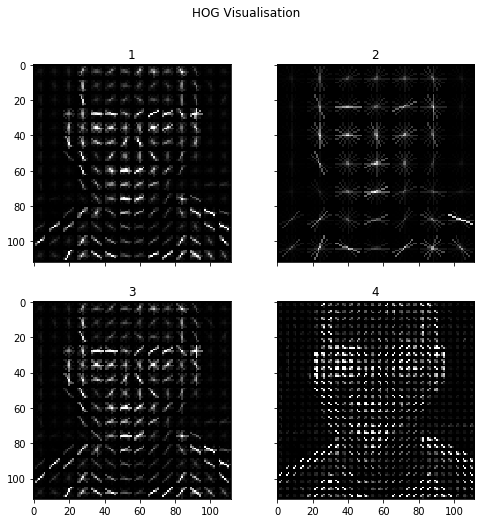

In [73]:
fig, axes=plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True)
fig.suptitle("HOG Visualisation")
axes[0,0].imshow(hog_image_rescaled1, cmap=plt.cm.gray)
axes[0,0].set_title('1')
axes[0,1].imshow(hog_image_rescaled2, cmap=plt.cm.gray)
axes[0,1].set_title('2')
axes[1,0].imshow(hog_image_rescaled3, cmap=plt.cm.gray)
axes[1,0].set_title('3')
axes[1,1].imshow(hog_image_rescaled4, cmap=plt.cm.gray)
axes[1,1].set_title('4')

Analysing cropped sample's HOG features

In [77]:
cropped_gray_im=cv2.cvtColor(cropped_sample,cv2.COLOR_RGB2GRAY)
fd1, hog_image1 = hog(cropped_gray_im, orientations=16, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled1 = exposure.rescale_intensity(hog_image1, in_range=(0, 0.02))
print("HOG vector dimension 1: ", fd1.shape)

fd2, hog_image2 = hog(cropped_gray_im, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled2 = exposure.rescale_intensity(hog_image2, in_range=(0, 0.02))
print("HOG vector dimension 2: ", fd2.shape)

fd3, hog_image3 = hog(cropped_gray_im, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled3 = exposure.rescale_intensity(hog_image3, in_range=(0, 0.02))
print("HOG vector dimension 3: " , fd3.shape)

fd4, hog_image4 = hog(cropped_gray_im, orientations=16, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled4 = exposure.rescale_intensity(hog_image4, in_range=(0, 0.02))
print("HOG vector dimension 4: ", fd4.shape)

('HOG vector dimension 1: ', (896,))
('HOG vector dimension 2: ', (112,))
('HOG vector dimension 3: ', (448,))
('HOG vector dimension 4: ', (4032,))


Text(0.5,1,'4')

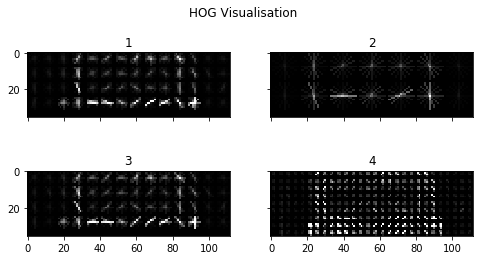

In [78]:
fig, axes=plt.subplots(2,2,figsize=(8,4),sharex=True,sharey=True)
fig.suptitle("HOG Visualisation")
axes[0,0].imshow(hog_image_rescaled1, cmap=plt.cm.gray)
axes[0,0].set_title('1')
axes[0,1].imshow(hog_image_rescaled2, cmap=plt.cm.gray)
axes[0,1].set_title('2')
axes[1,0].imshow(hog_image_rescaled3, cmap=plt.cm.gray)
axes[1,0].set_title('3')
axes[1,1].imshow(hog_image_rescaled4, cmap=plt.cm.gray)
axes[1,1].set_title('4')

## Dataset specific processing

### DISFA

In [33]:
import pandas as pd

In [34]:
DISFA_path='/media/amogh/Stuff/CMU/datasets/DISFA_data/'
DISFA_AU_path=DISFA_path+'ActionUnit_Labels/'
print(DISFA_AU_path)
Videos_right_path=DISFA_path+'Videos_RightCamera/'
print(Videos_right_path)

/media/amogh/Stuff/CMU/datasets/DISFA_data/ActionUnit_Labels/
/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/


Lets take 5 random samples frome each folder and take their max to get the max of eyebrow height. That would allow us to crop the image and get the HOG features

In [35]:
folder_list=glob.glob(Videos_right_path+"/*/")
folder_list

[]

In [17]:
random.choice(os.listdir(folder_list[0]))

'2743.jpeg'

  7%|▋         | 2/27 [00:05<01:08,  2.73s/it]

('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN003/1858_landmarks1.txt')


 15%|█▍        | 4/27 [00:10<01:00,  2.62s/it]

('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN005/4521_landmarks1.txt')


100%|██████████| 27/27 [01:10<00:00,  2.61s/it]


('top_list is: ', [35.25, 36.75, 36.0, 36.75, 36.25, 36.0, 36.0, 36.0, 37.5, 37.0, 36.0, 36.0, 37.0, 36.5, 37.0, 37.0, 37.0, 37.0, 36.75, 37.0, 36.0, 36.0, 36.0, 37.75, 37.25, 35.0, 35.75])
('max is: ', 37.75)


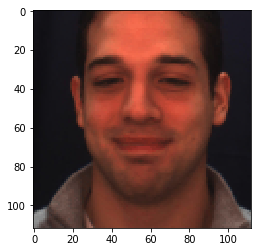

In [53]:
top_list=[]
error_list=[]
for fol in tqdm(folder_list):
    random_sample=[]
    for i in range(5):
        random_image_name=random.choice(os.listdir(fol))
        try:
            random_alignedAndCropped,landmarkPoints=detectAndaligncrop(fol+random_image_name)
        except:
            error_list.append(fol+random_image_name)
            print("error detected in", fol+random_image_name)
            continue
        top_eyes=np.average([y for _,y in landmarkPoints[np.array([37,38,43,44])]])
        random_sample.append(top_eyes)
    top_list.append(max(random_sample))
print("top_list is: ", top_list)
print("max is: ", max(top_list))

So the max is about 38, to get the top part of the face, let's see what the cropped part looks like for 3 random images in each of the folders.

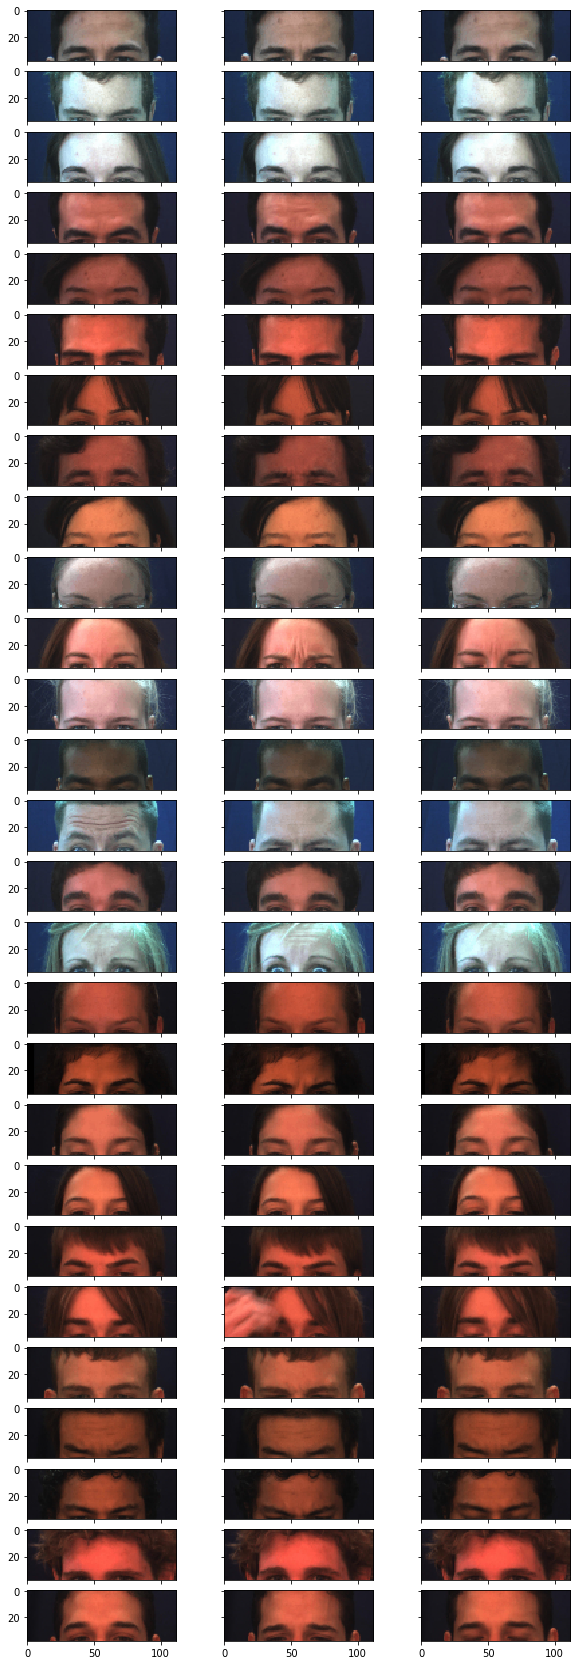

In [100]:
validate_fig,validate_axes=plt.subplots(len(folder_list),3,sharex=True,sharey=True,figsize=(10,30))
# validate_axes[0,0].imshow(sample_alignedAndCropped[0:top_eyes])
top_eyes=38
for f_no,fol in enumerate(folder_list):
    for i in range(3):
        random_image_name=random.choice(os.listdir(fol))
        try:
            random_alignedAndCropped,landmarkPoints=detectAndaligncrop(fol+random_image_name)
            validate_axes[f_no,i].imshow(random_alignedAndCropped[0:(top_eyes)])
        except:
            print("error detected in", fol+random_image_name)
            continue

Visualising for HOG

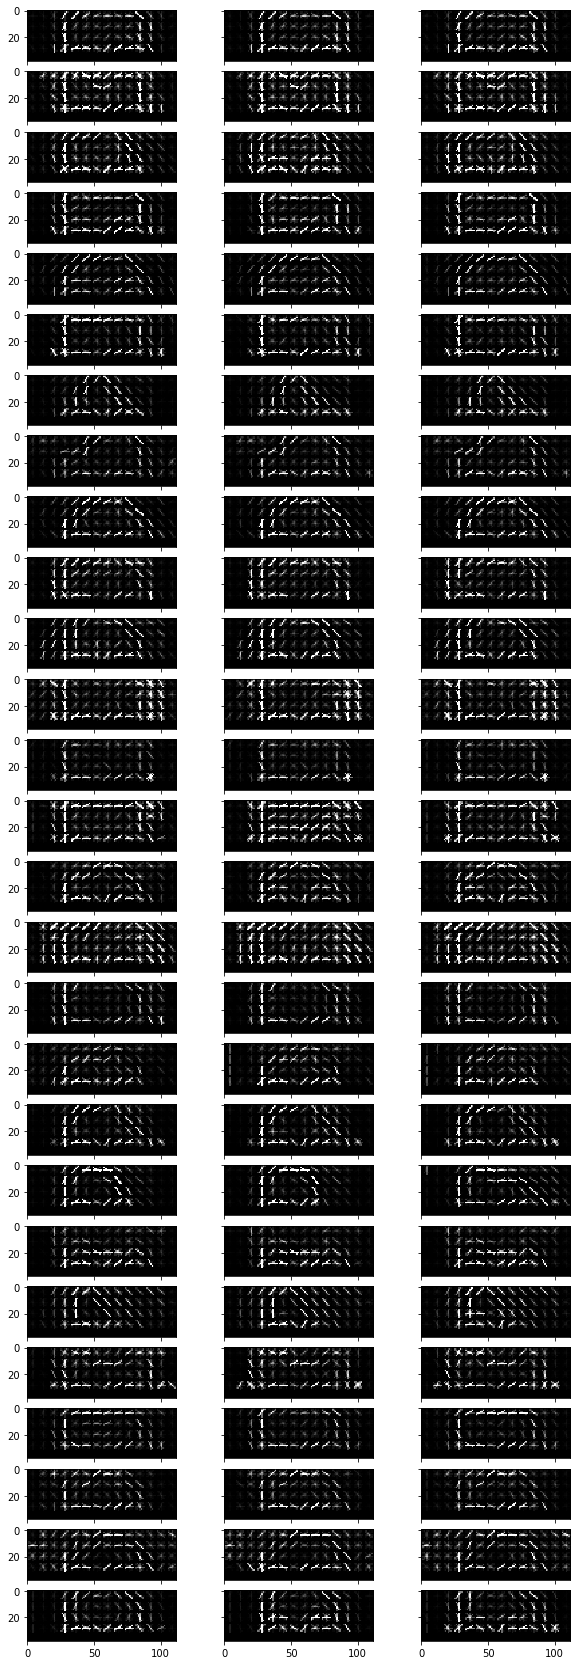

In [31]:
validate_fig,validate_axes=plt.subplots(len(folder_list),3,sharex=True,sharey=True,figsize=(10,30))
top_eyes=38
# validate_axes[0,0].imshow(sample_alignedAndCropped[0:top_eyes])
for f_no,fol in enumerate(folder_list):
    for i in range(3):
        random_image_name=random.choice(os.listdir(fol))
        try:
            random_alignedAndCropped,landmarkPoints=detectAndaligncrop(fol+random_image_name)
            cropped_im=random_alignedAndCropped[0:top_eyes]
            gray_cropped_im=cv2.cvtColor(cropped_im,cv2.COLOR_RGB2GRAY)
            fd, hog_image = hog(gray_cropped_im, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1), visualise=True)
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
            validate_axes[f_no,i].imshow(hog_image_rescaled,cmap=plt.cm.gray)
        except:
            print("error detected in", fol+random_image_name)
            continue

For the masked case:

('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN003/2774_landmarks1.txt')
('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN016/3743_landmarks1.txt')
('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN018/2421_landmarks1.txt')
('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN021/2114_landmarks1.txt')


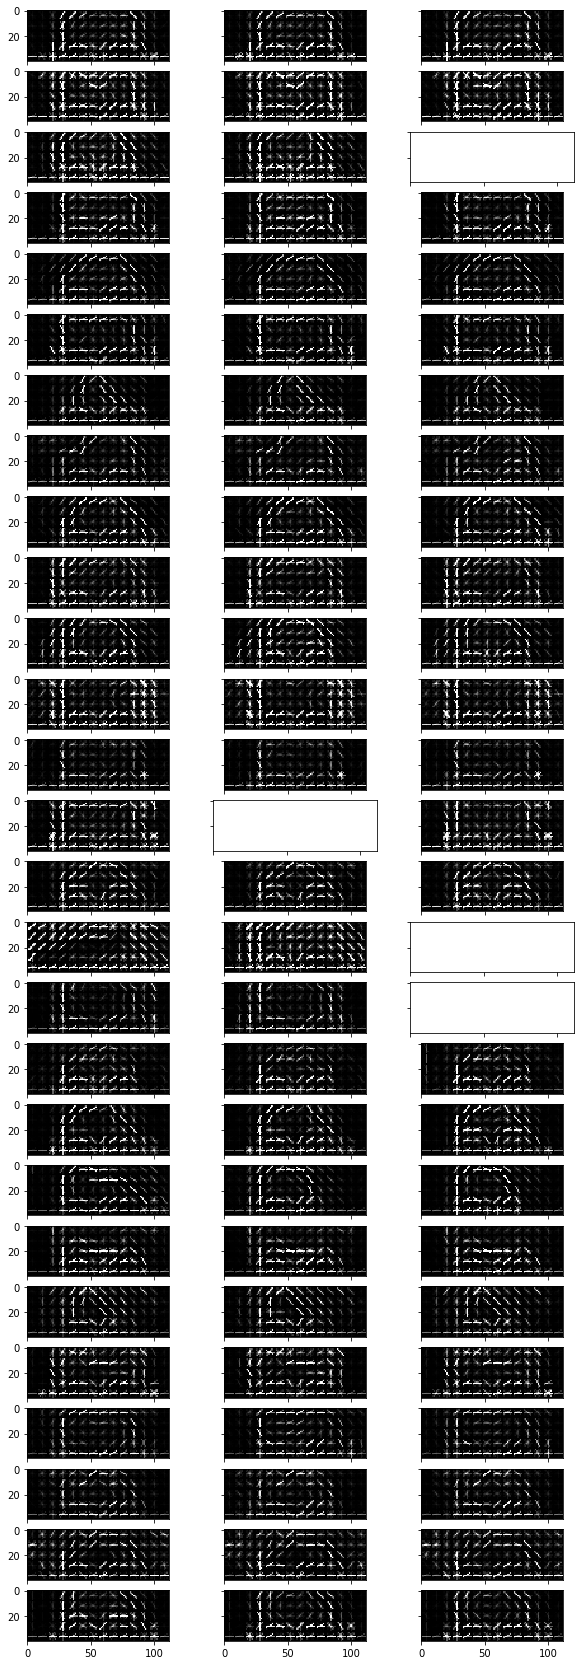

In [104]:
validate_fig,validate_axes=plt.subplots(len(folder_list),3,sharex=True,sharey=True,figsize=(10,30))
# validate_axes[0,0].imshow(sample_alignedAndCropped[0:top_eyes])
for f_no,fol in enumerate(folder_list):
    for i in range(3):
        random_image_name=random.choice(os.listdir(fol))
        try:
            random_alignedAndCropped,landmarkPoints=detectAndaligncrop(fol+random_image_name)
            top_eyes=np.max([y for _,y in landmarkPoints[np.array([37,38,43,44])]])
            threshold=min(40, int(top_eyes))
            masked_im=np.vstack((random_alignedAndCropped[:int(top_eyes)],np.zeros((40-threshold,112,3),np.float32)))
            gray_cropped_im=cv2.cvtColor(masked_im,cv2.COLOR_RGB2GRAY)
            fd, hog_image = hog(gray_cropped_im, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1), visualise=True)
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
            validate_axes[f_no,i].imshow(hog_image_rescaled,cmap=plt.cm.gray)
        except:
            print("error detected in", fol+random_image_name)
            continue

Changing HOG parameters: 

('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN005/1163_landmarks1.txt')
('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN008/2467_landmarks1.txt')
('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN029/4501.jpeg')


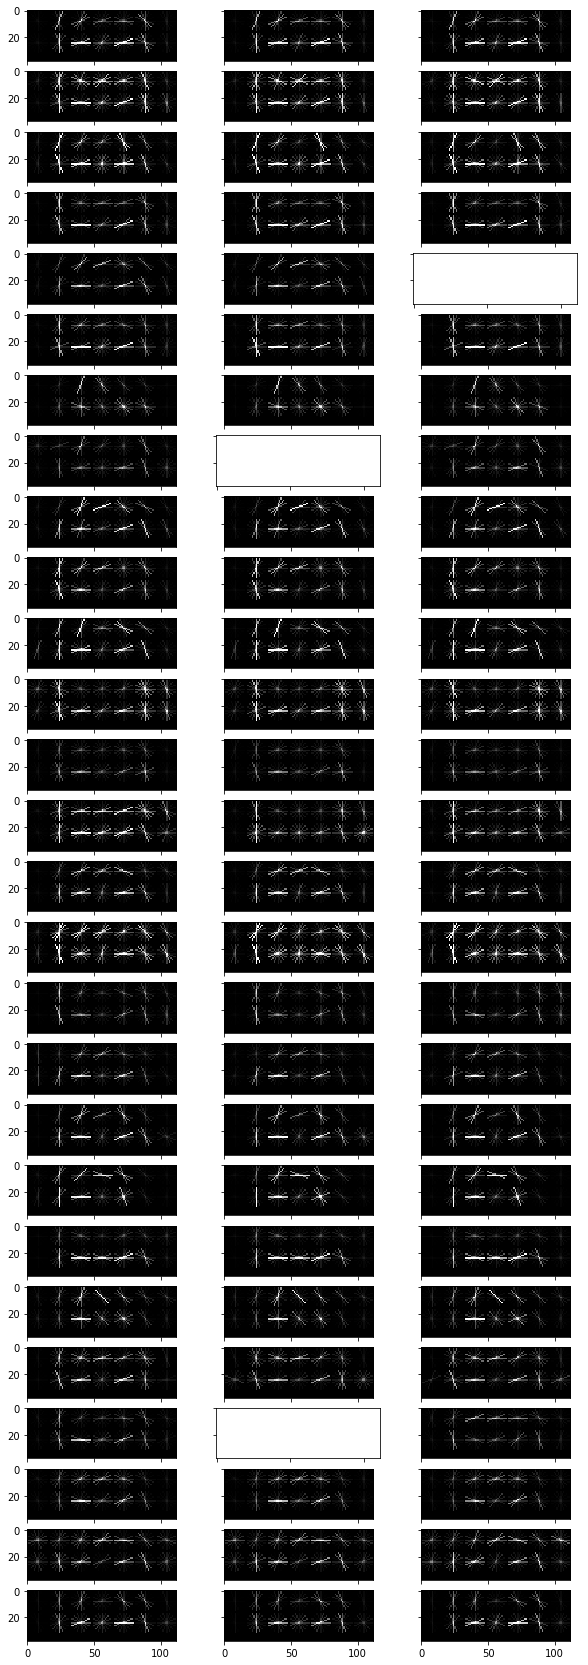

In [32]:
validate_fig,validate_axes=plt.subplots(len(folder_list),3,sharex=True,sharey=True,figsize=(10,30))
top_eyes=38
# validate_axes[0,0].imshow(sample_alignedAndCropped[0:top_eyes])
for f_no,fol in enumerate(folder_list):
    for i in range(3):
        random_image_name=random.choice(os.listdir(fol))
        try:
            random_alignedAndCropped,landmarkPoints=detectAndaligncrop(fol+random_image_name)
            cropped_im=random_alignedAndCropped[0:top_eyes]
            gray_cropped_im=cv2.cvtColor(cropped_im,cv2.COLOR_RGB2GRAY)
            fd, hog_image = hog(gray_cropped_im, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualise=True)
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
            validate_axes[f_no,i].imshow(hog_image_rescaled,cmap=plt.cm.gray)
        except:
            print("error detected in", fol+random_image_name)
            continue

**Let's deal with FAU4**

Loading the counts - csv which contains the counts corresponding to every FAU in DISFA

In [36]:
df_counts=pd.read_csv('DISFA_FAUs/count_summary.csv')
df_counts

,Unnamed: 0,SN001,SN001_neg,SN002,SN002_neg,SN003,SN003_neg,SN004,SN004_neg,SN005,...,SN028,SN028_neg,SN029,SN029_neg,SN030,SN030_neg,SN031,SN031_neg,SN032,SN032_neg
0,count_FAU1,0.0,4845.0,152.0,4693.0,496.0,4349.0,1086.0,3759.0,26.0,...,0.0,4845.0,1008.0,3837.0,38.0,4807.0,23.0,4822.0,870.0,3975.0
1,count_FAU2,0.0,4845.0,166.0,4679.0,18.0,4827.0,1167.0,3678.0,4.0,...,23.0,4822.0,1949.0,2896.0,173.0,4672.0,30.0,4815.0,182.0,4663.0
2,count_FAU4,29.0,4816.0,10.0,4835.0,1752.0,3093.0,1546.0,3299.0,245.0,...,145.0,4700.0,2246.0,2599.0,405.0,4440.0,183.0,4662.0,1073.0,3772.0
3,count_FAU5,0.0,4845.0,9.0,4836.0,21.0,4824.0,53.0,4792.0,0.0,...,4.0,4841.0,20.0,4825.0,56.0,4789.0,0.0,4845.0,4.0,4841.0
4,count_FAU12,408.0,4437.0,273.0,4572.0,629.0,4216.0,765.0,4080.0,140.0,...,359.0,4486.0,627.0,4218.0,783.0,4062.0,1155.0,3690.0,608.0,4237.0
5,count_FAU25,249.0,4596.0,1071.0,3774.0,1777.0,3068.0,838.0,4007.0,741.0,...,1476.0,3369.0,383.0,4462.0,1552.0,3293.0,1809.0,3036.0,3067.0,1778.0
6,count_FAU26,186.0,4659.0,1680.0,3165.0,811.0,4034.0,71.0,4774.0,484.0,...,1585.0,3260.0,31.0,4814.0,253.0,4592.0,1475.0,3370.0,2153.0,2692.0


Seeing the number of positives for each FAU

In [37]:
df_counts.sum(1)-df_counts.filter(like="neg",axis=1).sum(1) #subtracting the sum of all columns containing "neg" from the sum of all columns(total count)

0     6506.0
1     5644.0
2    19933.0
3     1150.0
4    16851.0
5    36247.0
6    11533.0
dtype: float64

In [38]:
df_fau4=pd.read_csv('DISFA_FAUs/FAU4.csv')
df_fau4.head()

,SN001,SN001_neg,SN002,SN002_neg,SN003,SN003_neg,SN004,SN004_neg,SN005,SN005_neg,...,SN028,SN028_neg,SN029,SN029_neg,SN030,SN030_neg,SN031,SN031_neg,SN032,SN032_neg
0,1338.0,1.0,434.0,1,938.0,1.0,1495.0,1.0,992.0,1.0,...,1733.0,1.0,102.0,1.0,1582.0,1.0,1620.0,1.0,1441.0,1.0
1,1339.0,2.0,435.0,2,939.0,2.0,1496.0,2.0,993.0,2.0,...,1734.0,2.0,103.0,2.0,1583.0,2.0,1621.0,2.0,1442.0,2.0
2,1340.0,3.0,1072.0,3,940.0,3.0,1497.0,3.0,994.0,3.0,...,1735.0,3.0,104.0,3.0,1584.0,3.0,1622.0,3.0,1443.0,3.0
3,1341.0,4.0,1073.0,4,941.0,4.0,1498.0,4.0,995.0,4.0,...,1736.0,4.0,105.0,4.0,1585.0,4.0,1623.0,4.0,1444.0,4.0
4,1342.0,5.0,1074.0,5,942.0,5.0,1499.0,5.0,996.0,5.0,...,1737.0,5.0,106.0,5.0,1586.0,5.0,1624.0,5.0,1445.0,5.0


In [39]:
df_negatives= df_fau4.filter(like="neg",axis=1)
df_negatives.head()

,SN001_neg,SN002_neg,SN003_neg,SN004_neg,SN005_neg,SN006_neg,SN007_neg,SN008_neg,SN009_neg,SN010_neg,...,SN023_neg,SN024_neg,SN025_neg,SN026_neg,SN027_neg,SN028_neg,SN029_neg,SN030_neg,SN031_neg,SN032_neg
0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,3.0,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,4.0,4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,5.0,5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [40]:
df_positives=df_fau4.filter(regex="^((?!neg).)*$",axis=1)
df_positives.head()

,SN001,SN002,SN003,SN004,SN005,SN006,SN007,SN008,SN009,SN010,...,SN023,SN024,SN025,SN026,SN027,SN028,SN029,SN030,SN031,SN032
0,1338.0,434.0,938.0,1495.0,992.0,1102.0,1669.0,944.0,1527.0,948.0,...,1497.0,1672.0,861.0,1682.0,963.0,1733.0,102.0,1582.0,1620.0,1441.0
1,1339.0,435.0,939.0,1496.0,993.0,1103.0,1670.0,945.0,1528.0,949.0,...,1498.0,1673.0,862.0,1683.0,964.0,1734.0,103.0,1583.0,1621.0,1442.0
2,1340.0,1072.0,940.0,1497.0,994.0,1104.0,1671.0,946.0,1529.0,950.0,...,1499.0,1674.0,863.0,1684.0,965.0,1735.0,104.0,1584.0,1622.0,1443.0
3,1341.0,1073.0,941.0,1498.0,995.0,1105.0,1672.0,947.0,1530.0,951.0,...,1500.0,1675.0,864.0,1685.0,966.0,1736.0,105.0,1585.0,1623.0,1444.0
4,1342.0,1074.0,942.0,1499.0,996.0,1106.0,1673.0,948.0,1531.0,952.0,...,1501.0,1676.0,865.0,1686.0,967.0,1737.0,106.0,1586.0,1624.0,1445.0


**No of positives for each subject in  FAU4**

In [41]:
df_positives.count(0)

SN001      29
SN002      10
SN003    1752
SN004    1546
SN005     245
SN006     319
SN007      51
SN008     624
SN009      25
SN010      92
SN011    3254
SN012     426
SN013     244
SN016    2937
SN017     159
SN018    1229
SN021     794
SN023    1480
SN024      59
SN025      58
SN026      43
SN027     505
SN028     145
SN029    2246
SN030     405
SN031     183
SN032    1073
dtype: int64

**Total positives for FAU4**

In [51]:
df_positives.count(0).sum()

19933

Defining functions to **load file names** corresponding to a **number of subjects** and a **variable** to store filenames in 

In [52]:
def loadPositiveFiles(no_of_subjects,storing_variable):
    for subj in df_positives.columns[:no_of_subjects+1]:
        for frame in df_positives[subj]:
            if not math.isnan(frame):
                file_path=Videos_right_path+"RightVideo{}/{}.jpeg".format(subj,int(frame))
                if os.path.exists(file_path):
                    storing_variable.append(file_path)
    print("number of files stored are: ", len(storing_variable), " and examples are: " , storing_variable[:2]) #sanity check

In [53]:
def loadPositiveTestFiles(no_of_subjects,storing_variable):
    for subj in df_positives.columns[no_of_subjects+1:]:
        for frame in df_positives[subj]:
            if not math.isnan(frame):
                file_path=Videos_right_path+"RightVideo{}/{}.jpeg".format(subj,int(frame))
                if os.path.exists(file_path):
                    storing_variable.append(file_path)
    print("number of files stored are: ", len(storing_variable), " and examples are: " , storing_variable[:2]) #sanity check

In [54]:
def loadNegativeFiles(no_of_subjects,storing_variable):
    for subj in df_negatives.columns[:no_of_subjects+1]:
        for frame in df_negatives[subj]:
            if not math.isnan(frame):
                subj=subj.split('_')[0]
                file_path=Videos_right_path+"RightVideo{}/{}.jpeg".format(subj,int(frame))
                if os.path.exists(file_path):
                    storing_variable.append(file_path)
    print("number of files stored are: ", len(storing_variable)," and examples are: ",storing_variable[:2]) #sanity check

In [55]:
def loadNegativeTestFiles(no_of_subjects,storing_variable):
    for subj in df_negatives.columns[no_of_subjects+1:]:
        for frame in df_negatives[subj]:
            if not math.isnan(frame):
                subj=subj.split('_')[0]
                file_path=Videos_right_path+"RightVideo{}/{}.jpeg".format(subj,int(frame))
                if os.path.exists(file_path):
                    storing_variable.append(file_path)
    print("number of files stored are: ", len(storing_variable)," and examples are: ",storing_variable[:2]) #sanity check

**Let's load filenames for 20 subjects for both positives and negatives**

In [56]:
list_positive_fau4_files=[]
loadPositiveFiles(20,list_positive_fau4_files)

('number of files stored are: ', 15376, ' and examples are: ', ['/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN001/1338.jpeg', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN001/1339.jpeg'])


In [57]:
list_positive_test_fau4_files=[]
loadPositiveTestFiles(20,list_positive_test_fau4_files)

('number of files stored are: ', 4557, ' and examples are: ', ['/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN027/963.jpeg', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN027/964.jpeg'])


In [58]:
list_negative_fau4_files=[]
loadNegativeFiles(20,list_negative_fau4_files)

('number of files stored are: ', 86368, ' and examples are: ', ['/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN001/1.jpeg', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN001/2.jpeg'])


In [59]:
list_negative_test_fau4_files=[]
loadNegativeTestFiles(20,list_negative_test_fau4_files)

('number of files stored are: ', 24513, ' and examples are: ', ['/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN027/1.jpeg', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN027/2.jpeg'])


Things that can be done to improve the performance, 
- Increase threshold for FAU positive.
- Try different configurations for HOG

In [60]:
dir_cropped_FAU4_1=DISFA_path+"/features/cropped_images/FAU4_1/"
print(dir_cropped_FAU4_1)
if not os.path.exists(dir_cropped_FAU4_1):
    os.makedirs(dir_cropped_FAU4_1)
    
dir_cropped_FAU4_1_positives=dir_cropped_FAU4_1+"positives/"
print(dir_cropped_FAU4_1_positives)
if not os.path.exists(dir_cropped_FAU4_1_positives):
    os.makedirs(dir_cropped_FAU4_1_positives)
    
dir_cropped_FAU4_1_positives_test=dir_cropped_FAU4_1+"positives/test/"
print(dir_cropped_FAU4_1_positives_test)
if not os.path.exists(dir_cropped_FAU4_1_positives_test):
    os.makedirs(dir_cropped_FAU4_1_positives_test)
    
dir_cropped_FAU4_1_negatives=dir_cropped_FAU4_1+"negatives/"
print(dir_cropped_FAU4_1_negatives)
if not os.path.exists(dir_cropped_FAU4_1_negatives):
    os.makedirs(dir_cropped_FAU4_1_negatives)
    
dir_cropped_FAU4_1_negatives_test=dir_cropped_FAU4_1+"negatives/test/"
print(dir_cropped_FAU4_1_negatives_test)
if not os.path.exists(dir_cropped_FAU4_1_negatives_test):
    os.makedirs(dir_cropped_FAU4_1_negatives_test)

/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_1/
/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_1/positives/
/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_1/positives/test/
/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_1/negatives/
/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_1/negatives/test/


In [88]:
list_negative_fau4_files[1].split("/")[-2]+"/"+list_negative_fau4_files[1].split("/")[-1].split(".")[0]+".png"

'RightVideoSN001/2.png'

**Saving cropped images for FAU4 positives**  (don't run, takes a lot of time; if you have to run remove :5)

Defining the function which takes as the parameters **list of file paths, number of images from the lsit of file paths and the destination folder to save the files to**

In [61]:
def shuffleCropSave(image_file_list, num_images, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    np.random.shuffle(image_file_list)
    for f in tqdm(image_file_list[:num_images]):
        try:
            random_alignedAndCropped,landmarkPoints=detectAndaligncrop(f)
            cropped_im=random_alignedAndCropped[0:top_eyes]
            gray_cropped_im=cv2.cvtColor(cropped_im,cv2.COLOR_RGB2GRAY)
            file_name=f.split("/")[-2]+"_"+f.split("/")[-1].split(".")[0]+".png"
            file_dest=dest_folder+file_name
            cv2.imwrite(file_dest,gray_cropped_im*255.)
    #         fd, hog_image = hog(gray_cropped_im, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualise=True)
    #         hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
        except KeyboardInterrupt:
            break
        except:
            print("error detected in", f)
            continue

Saving 2000 images from positives and negatives from first 20 subjects:

In [129]:
shuffleCropSave(list_positive_fau4_files,2000,dir_cropped_FAU4_1_positives)

NameError: name 'shuffleCropSave2' is not defined

In [ ]:
shuffleCropSave(list_negative_fau4_files,2000,dir_cropped_FAU4_1_negatives)

 77%|███████▋  | 1542/2000 [13:33<04:01,  1.89it/s]

('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN009/1740.jpeg')


 89%|████████▊ | 1773/2000 [15:40<02:00,  1.89it/s]

('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN009/1768.jpeg')


 92%|█████████▎| 1850/2000 [16:24<01:19,  1.88it/s]

In [ ]:
shuffleCropSave(list_positive_test_fau4_files,500,dir_cropped_FAU4_1_positives_test)

In [ ]:
shuffleCropSave(list_negative_test_fau4_files,500,dir_cropped_FAU4_1_negatives_test)

Now that the cropped grayscale images have been saved, we can load them, **process hog and save the features.**

**Saving cropped images for FAU4 negatives**  (don't run, takes a lot of time; if you have to run remove :5)

Now that the cropped grayscale images have been saved, we can load them, process hog and save the features.

Defining function which takes the path of the cropped images and an array to append the calculated HOG features to

In [96]:
def calcHOGfeatures(cropped_im_path,features_holder):
    list_cropped_files=os.listdir(cropped_im_path)
    for f in tqdm(list_cropped_files):
        try:
            im=cv2.imread(cropped_im_path+f,0)
            fd, hog_image = hog(im, orientations=8, pixels_per_cell=(8,8),cells_per_block=(1, 1), visualise=True)
            features_holder=np.append(features_holder,[fd],axis=0)
        except KeyboardInterrupt:
            break
        except:
            print("error detected in", f)
            continue
    print ("The shape of HOG features vector is: ",features_holder.shape)
    return features_holder

Calculating HOG features and storing them

In [ ]:
features_fau4_1_hog_1_positives=np.empty((0,448))
features_fau4_1_hog_1_positives=calcHOGfeatures(dir_cropped_FAU4_1_positives,features_fau4_1_hog_1_positives)

In [ ]:
features_fau4_1_hog_1_negatives=np.empty((0,448))
features_fau4_1_hog_1_negatives=calcHOGfeatures(dir_cropped_FAU4_1_negatives,features_fau4_1_hog_1_negatives)

In [ ]:
features_fau4_1_hog_1_positives_test=np.empty((0,448))
features_fau4_1_hog_1_positives_test=calcHOGfeatures(dir_cropped_FAU4_1_positives_test,features_fau4_1_hog_1_positives_test)

In [ ]:
features_fau4_1_hog_1_negatives_test=np.empty((0,448))
features_fau4_1_hog_1_negatives_test=calcHOGfeatures(dir_cropped_FAU4_1_negatives_test,features_fau4_1_hog_1_negatives_test)

Saving the arrays **features_fau4_1_hog_1_negatives** and **features_fau4_1_hog_1_positives** as bcolz carray

In [122]:
features_fau4_1_hog_1_negatives.shape

(1898, 448)

Make a folder for hog features:

In [103]:
dir_features_hog_1_fau4_1=DISFA_path+"/features/hog_1/fau4_1/"
dir_features_hog_1_fau4_1
if not os.path.exists(dir_features_hog_1_fau4_1):
    os.makedirs(dir_features_hog_hog_1_fau4_1)

In [104]:
dir_features_hog_1_fau4_1_test=DISFA_path+"/features/hog_1/fau4_1/"
dir_features_hog_1_fau4_1_test
if not os.path.exists(dir_features_hog_1_fau4_1_test):
    os.makedirs(dir_features_hog_hog_1_fau4_1_test)

In [105]:
#save positives
save1=carray(features_fau4_1_hog_1_positives,rootdir=dir_features_hog_1_fau4_1+'positives/',mode='w')
save1.flush()
#save negatives
save2=carray(features_fau4_1_hog_1_negatives,rootdir=dir_features_hog_1_fau4_1+'negatives/',mode='w')
save2.flush()

In [123]:
#save positives
save1=carray(features_fau4_1_hog_1_positives_test,rootdir=dir_features_hog_1_fau4_1+'positives_test/',mode='w')
save1.flush()
#save negatives
save2=carray(features_fau4_1_hog_1_negatives_test,rootdir=dir_features_hog_1_fau4_1+'negatives_test/',mode='w')
save2.flush()

Loading the saved arrays

In [124]:
features_fau4_1_hog_1_positives=carray(rootdir=dir_features_hog_1_fau4_1+'positives/',mode='r')
features_fau4_1_hog_1_positives.shape

(2000, 448)

In [125]:
features_fau4_1_hog_1_positives_test=carray(rootdir=dir_features_hog_1_fau4_1+'positives_test/',mode='r')
features_fau4_1_hog_1_positives_test.shape

(464, 448)

In [126]:
features_fau4_1_hog_1_negatives=carray(rootdir=dir_features_hog_1_fau4_1+'negatives/',mode='r')
features_fau4_1_hog_1_negatives.shape

(1898, 448)

In [127]:
features_fau4_1_hog_1_negatives_test=carray(rootdir=dir_features_hog_1_fau4_1+'negatives_test/',mode='r')
features_fau4_1_hog_1_negatives_test.shape

(499, 448)

We have two numpy arrays with HOG features for FAU4- **features_fau4_1_hog_1_negatives** and **features_fau4_1_hog_1_positives**

### FAU4_2

Doing the same for masked images below eyes by naming these features as FAU4_2:

In [62]:
dir_cropped_FAU4_2=DISFA_path+"/features/cropped_images/FAU4_2/"
print(dir_cropped_FAU4_2)
if not os.path.exists(dir_cropped_FAU4_2):
    os.makedirs(dir_cropped_FAU4_2)
    
dir_cropped_FAU4_2_positives=dir_cropped_FAU4_2+"positives/"
print(dir_cropped_FAU4_2_positives)
if not os.path.exists(dir_cropped_FAU4_2_positives):
    os.makedirs(dir_cropped_FAU4_2_positives)
    
dir_cropped_FAU4_2_positives_test=dir_cropped_FAU4_2+"positives/test/"
print(dir_cropped_FAU4_2_positives_test)
if not os.path.exists(dir_cropped_FAU4_2_positives_test):
    os.makedirs(dir_cropped_FAU4_2_positives_test)
    
dir_cropped_FAU4_2_negatives=dir_cropped_FAU4_2+"negatives/"
print(dir_cropped_FAU4_2_negatives)
if not os.path.exists(dir_cropped_FAU4_2_negatives):
    os.makedirs(dir_cropped_FAU4_2_negatives)
    
dir_cropped_FAU4_2_negatives_test=dir_cropped_FAU4_2+"negatives/test/"
print(dir_cropped_FAU4_2_negatives_test)
if not os.path.exists(dir_cropped_FAU4_2_negatives_test):
    os.makedirs(dir_cropped_FAU4_2_negatives_test)

/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_2/
/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_2/positives/
/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_2/positives/test/
/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_2/negatives/
/media/amogh/Stuff/CMU/datasets/DISFA_data//features/cropped_images/FAU4_2/negatives/test/


In [63]:
def shuffleCropSave2(image_file_list, num_images, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    np.random.shuffle(image_file_list)
    for f in tqdm(image_file_list[:num_images]):
        try:
            random_alignedAndCropped,landmarkPoints=detectAndaligncrop(f)
            top_eyes=np.max([y for _,y in landmarkPoints[np.array([37,38,43,44])]])
            threshold=min(40, int(top_eyes))
#             masked_im=np.vstack((random_alignedAndCropped[:int(top_eyes)],np.zeros((40-threshold,112,3),np.float32)))
            masked_im=random_alignedAndCropped[:int(top_eyes)]
            gray_cropped_im=cv2.cvtColor(masked_im,cv2.COLOR_RGB2GRAY)
            file_name=f.split("/")[-2]+"_"+f.split("/")[-1].split(".")[0]+".png"
            file_dest=dest_folder+file_name
            cv2.imwrite(file_dest,gray_cropped_im*255.)
    #         fd, hog_image = hog(gray_cropped_im, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualise=True)
    #         hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
        except KeyboardInterrupt:
            break
        except:
            print("error detected in", f)
            continue

In [ ]:
shuffleCropSave2(list_positive_fau4_files,2000,dir_cropped_FAU4_2_positives)




  0%|          | 0/2000 [00:00<?, ?it/s]


  0%|          | 1/2000 [00:00<17:46,  1.87it/s]


  0%|          | 2/2000 [00:01<17:42,  1.88it/s]


  0%|          | 3/2000 [00:01<18:09,  1.83it/s]


  0%|          | 4/2000 [00:02<17:57,  1.85it/s]


  0%|          | 5/2000 [00:02<17:54,  1.86it/s]


  0%|          | 6/2000 [00:03<17:51,  1.86it/s]


  0%|          | 7/2000 [00:03<17:45,  1.87it/s]


  0%|          | 8/2000 [00:04<17:52,  1.86it/s]


  0%|          | 9/2000 [00:04<17:47,  1.86it/s]


  0%|          | 10/2000 [00:05<17:53,  1.85it/s]


  1%|          | 11/2000 [00:05<17:57,  1.85it/s]


  1%|          | 12/2000 [00:06<17:53,  1.85it/s]


  1%|          | 13/2000 [00:07<18:02,  1.84it/s]


  1%|          | 14/2000 [00:07<18:05,  1.83it/s]


  1%|          | 15/2000 [00:08<18:30,  1.79it/s]


  1%|          | 16/2000 [00:08<18:32,  1.78it/s]


  1%|          | 17/2000 [00:09<18:44,  1.76it/s]


  1%|          | 18/2000 [00:10<18:43,  1.76it/s]


  1%|          | 19/2000 [0

In [ ]:
shuffleCropSave2(list_negative_fau4_files,2000,dir_cropped_FAU4_2_negatives)

 77%|███████▋  | 1542/2000 [13:33<04:01,  1.89it/s]

('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN009/1740.jpeg')


 89%|████████▊ | 1773/2000 [15:40<02:00,  1.89it/s]

('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN009/1768.jpeg')


 92%|█████████▎| 1850/2000 [16:24<01:19,  1.88it/s]

In [ ]:
shuffleCropSave2(list_positive_test_fau4_files,500,dir_cropped_FAU4_2_positives_test)

In [ ]:
shuffleCropSave2(list_negative_test_fau4_files,500,dir_cropped_FAU4_2_negatives_test)

In [96]:
def calcHOGfeatures(cropped_im_path,features_holder, orientations,pixels_per_cell,cell_per_block):
    list_cropped_files=os.listdir(cropped_im_path)
    for f in tqdm(list_cropped_files):
        try:
            im=cv2.imread(cropped_im_path+f,0)
            fd, hog_image = hog(im, orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block, visualise=True)
            features_holder=np.append(features_holder,[fd],axis=0)
        except KeyboardInterrupt:
            break
        except:
            print("error detected in", f)
            continue
    print ("The shape of HOG features vector is: ",features_holder.shape)
    return features_holder

Calculating HOG features and storing them

In [ ]:
features_fau4_1_hog_1_positives=np.empty((0,448))
features_fau4_1_hog_1_positives=calcHOGfeatures(dir_cropped_FAU4_1_positives,features_fau4_1_hog_1_positives)

In [ ]:
features_fau4_1_hog_1_negatives=np.empty((0,448))
features_fau4_1_hog_1_negatives=calcHOGfeatures(dir_cropped_FAU4_1_negatives,features_fau4_1_hog_1_negatives)

In [ ]:
features_fau4_1_hog_1_positives_test=np.empty((0,448))
features_fau4_1_hog_1_positives_test=calcHOGfeatures(dir_cropped_FAU4_1_positives_test,features_fau4_1_hog_1_positives_test)

In [ ]:
features_fau4_1_hog_1_negatives_test=np.empty((0,448))
features_fau4_1_hog_1_negatives_test=calcHOGfeatures(dir_cropped_FAU4_1_negatives_test,features_fau4_1_hog_1_negatives_test)

In [ ]:
def calcAndSaveHOGFeatures:
    

Saving the arrays **features_fau4_1_hog_1_negatives** and **features_fau4_1_hog_1_positives** as bcolz carray

In [122]:
features_fau4_1_hog_1_negatives.shape

(1898, 448)

Make a folder for hog features:

In [103]:
dir_features_hog_1_fau4_1=DISFA_path+"/features/hog_1/fau4_1/"
dir_features_hog_1_fau4_1
if not os.path.exists(dir_features_hog_1_fau4_1):
    os.makedirs(dir_features_hog_hog_1_fau4_1)

In [104]:
dir_features_hog_1_fau4_1_test=DISFA_path+"/features/hog_1/fau4_1/"
dir_features_hog_1_fau4_1_test
if not os.path.exists(dir_features_hog_1_fau4_1_test):
    os.makedirs(dir_features_hog_hog_1_fau4_1_test)

In [105]:
#save positives
save1=carray(features_fau4_1_hog_1_positives,rootdir=dir_features_hog_1_fau4_1+'positives/',mode='w')
save1.flush()
#save negatives
save2=carray(features_fau4_1_hog_1_negatives,rootdir=dir_features_hog_1_fau4_1+'negatives/',mode='w')
save2.flush()

In [123]:
#save positives
save1=carray(features_fau4_1_hog_1_positives_test,rootdir=dir_features_hog_1_fau4_1+'positives_test/',mode='w')
save1.flush()
#save negatives
save2=carray(features_fau4_1_hog_1_negatives_test,rootdir=dir_features_hog_1_fau4_1+'negatives_test/',mode='w')
save2.flush()

Let's make the pipeline a bit more modular:
Steps
- Read dataset image from a path
- Crop and align faces to a 112x112 size
- Preprocess(crop and save a relevant part, maybe mask) # give mask as a parameter
- Get HOG features- requires orientations, pixels per cell, cells per block; allow parameters to be set
- Save the HOG features